<a href="https://colab.research.google.com/github/praffuln/agentic-ai/blob/master/langgraph_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: print hello world

print("hello world")


hello world


In [ ]:
!pip install google-generativeai tiktoken chromadb langgraph langchain langchain_community langchainhub ipykernel langchain_groq sentence_transformers


In [1]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## Setup Keys For GOOGLE_API_KEY


In [3]:

# Assigning value to variable
GEMINI_API_KEY=''
SERPER_API_KEY = ''
GROQ_API_KEY = ''




# setup environments


In [4]:
import os
os.environ['SERPER_API_KEY'] = SERPER_API_KEY
os.environ['GEMINI_API_KEY'] = GEMINI_API_KEY
os.environ['GROQ_API_KEY'] = GROQ_API_KEY




## setup LLM

In [5]:
import google.generativeai as genai

genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)


AI doesn't work in a single, unified way.  Instead, it encompasses a broad range of techniques and approaches, all aiming to mimic aspects of human intelligence.  However, we can break down how many AI systems work into several key components:

**1. Data Collection and Preparation:**  This is the foundational step. AI systems, especially those based on machine learning, require massive amounts of data.  This data could be anything from images and text to sensor readings and financial transactions.  Crucially, this data needs to be cleaned, preprocessed, and formatted appropriately for the chosen AI algorithm. This might involve removing errors, handling missing values, and transforming data into a suitable representation (e.g., numerical vectors).

**2. Algorithm Selection:**  This involves choosing the appropriate algorithm or model based on the type of problem being solved and the nature of the data.  Some common algorithms include:

* **Supervised Learning:** The algorithm learns fr

In [ ]:
from langchain_groq import ChatGroq
from sentence_transformers import SentenceTransformer # Import SentenceTransformer instead of GroqEmbedding


llm = ChatGroq(model="mixtral-8x7b-32768")

llm.invoke("tell me something about ai")

# Now use SentenceTransformer for embedding
embedding_model = SentenceTransformer('all-mpnet-base-v2')  # Choose a suitable pre-trained model
embedding = embedding_model.encode("tell me something about ai")

print(embedding) # Print the embedding to see the result

## Load Data

In [7]:
urls= ["https://lilianweng.github.io/posts/2023-06-23-agent/",
      "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
      "https://en.wikipedia.org/wiki/Prompt_engineering",
       "https://en.wikipedia.org/wiki/Intelligent_agent"
       ]
docs = [WebBaseLoader(url).load() for url in urls]

docs[0][0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [8]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=5)
doc_splits=text_splitter.split_documents(docs_list)
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

## Insert split data into Chroma

In [9]:

from langchain_community.embeddings import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embedding_model
)


<ipython-input-9-8150bac59455>:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")


## Generate retriever

In [10]:
retriever=vectorstore.as_retriever()


### convert retriever to tool

In [11]:
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",

)

## Convert retriever into tool, tool will use by node

In [12]:
tools=[retriever_tool]

## Fuctions & Graph

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [15]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)

    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant.
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name


In [16]:
def ai_assistant(state):
    print("---CALL AGENT---")
    messages = state['messages']
    print(f"this is my message: {messages}")

    ## langchain bind_tools api used to enhance llm functionality
    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    #response=handle_query(messages)
    return {"messages": [response]}



    # print("---CALL AGENT---")
    # messages = state['messages']
    # print(f"this is my message: {messages}")

    # if len(messages)>1:
    #     response=llm.invoke(messages[-1].content)
    #     return {"messages": [response]}
    # else:
    #     llm_with_tool = llm.bind_tools(tools)
    #     response = llm_with_tool.invoke(messages)
    #     #response=handle_query(messages)
    #     return {"messages": [response]}


In [ ]:
def retrieve(state):
  pass

In [17]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    print(f"here is message from rewrite: {messages}")

    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning.
                    Here is the initial question: {question}
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}


In [18]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    print(f"here is message from generate: {messages}")

    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = """
                You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
                If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
                Question: {question}
                Context: {context}
                Answer:
            """

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")

    return {"messages": [response]}


In [19]:
workflow=StateGraph(AgentState)
workflow.add_node("ai_assistant",ai_assistant)
retrieve=ToolNode([retriever_tool])   ### way to add retriever_tool under node
workflow.add_node("retriever", retrieve)
workflow.add_node("rewriter", rewrite)
workflow.add_node("generator", generate)


In [20]:
workflow.add_edge(START, "ai_assistant")

workflow.add_conditional_edges("ai_assistant",
                               tools_condition,
                               {"tools": "retriever",
                                END: END,})

workflow.add_conditional_edges("retriever",
                            grade_documents,
                            {"generator": "generator",
                            "rewriter": "rewriter"
                            }
                            )

workflow.add_edge("generator", END)

workflow.add_edge("rewriter", "ai_assistant")


In [21]:
app = workflow.compile()

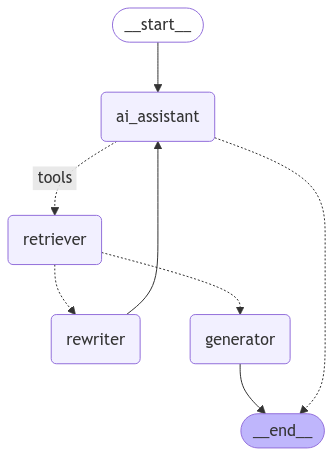

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
app.invoke({"messages": [HumanMessage(content="tell me something about ai")]})

---CALL AGENT---
this is my message: [HumanMessage(content='tell me something about ai', additional_kwargs={}, response_metadata={}, id='e904b533-c625-428c-88df-f3a0f4f8edcd')]


{'messages': [HumanMessage(content='tell me something about ai', additional_kwargs={}, response_metadata={}, id='e904b533-c625-428c-88df-f3a0f4f8edcd'),
  AIMessage(content="AI, or artificial intelligence, refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction.\n\nAI can be categorized as either weak or strong. Weak AI, also known as narrow AI, is an AI system that is designed and trained for a particular task. Virtual personal assistants, such as Apple's Siri, are a form of weak AI. Strong AI, also known as artificial general intelligence, is an AI system with generalized human cognitive abilities. When presented with an unfamiliar task, a strong AI system is able to find a solution without human intervention.\n\nAI is used in a variety of fields, incl

In [24]:
app.invoke({"messages": [HumanMessage(content="what is autonomous agent ?")]})

---CALL AGENT---
this is my message: [HumanMessage(content='what is autonomous agent ?', additional_kwargs={}, response_metadata={}, id='77756882-70ac-40ac-ad29-657eee3d17c5')]


{'messages': [HumanMessage(content='what is autonomous agent ?', additional_kwargs={}, response_metadata={}, id='77756882-70ac-40ac-ad29-657eee3d17c5'),
  AIMessage(content='An autonomous agent is a software entity that can independently perform tasks based on its programming and environmental inputs. It can make decisions, take actions, and adapt to changes in its environment without human intervention. Examples of autonomous agents include self-driving cars, chatbots, and manufacturing robots.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 1268, 'total_tokens': 1330, 'completion_time': 0.094135794, 'prompt_time': 0.066663439, 'queue_time': 0.020667680999999993, 'total_time': 0.160799233}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-a64a028d-5cae-4530-b880-30ad106e9372-0', usage_metadata={'input_tokens': 1268, 'output_tokens': 62, 'total_tokens': 133

In [25]:
app.invoke({"messages": [HumanMessage(content="who is the prime minister of India ?")]})

---CALL AGENT---
this is my message: [HumanMessage(content='who is the prime minister of India ?', additional_kwargs={}, response_metadata={}, id='cedce301-80e0-45c9-817c-4126b03ce814')]


{'messages': [HumanMessage(content='who is the prime minister of India ?', additional_kwargs={}, response_metadata={}, id='cedce301-80e0-45c9-817c-4126b03ce814'),
  AIMessage(content='The current prime minister of India is Narendra Modi. I did not need to use any tools to find this information.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 1270, 'total_tokens': 1298, 'completion_time': 0.041858952, 'prompt_time': 0.067337475, 'queue_time': 0.018746858000000005, 'total_time': 0.109196427}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'stop', 'logprobs': None}, id='run-d012882f-64c9-4989-a1df-6a74f934f4ab-0', usage_metadata={'input_tokens': 1270, 'output_tokens': 28, 'total_tokens': 1298})]}